<a href="https://colab.research.google.com/github/santolina/Tensorflow-Dev/blob/master/Image_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Perceptual Losses for Real-Time Style Transfer and Super-Resolution

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
#from tensorflow.keras.preprocessing.image import load_img,  img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [22]:
# download train data
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip

!unzip DIV2K_train_LR_x8.zip



--2019-12-03 12:42:42--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip [following]
--2019-12-03 12:42:42--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65753171 (63M) [application/zip]
Saving to: ‘DIV2K_train_LR_x8.zip.2’

DIV2K_train_LR_x8.z 100%[===================>]  62.71M  17.5MB/s    in 4.3s    

2019-12-03 12:42:47 (14.7 MB/s) - ‘DIV2K_train_LR_x8.zip.2’ saved [65753171/65753171]

Archive:  DIV2K_train_LR_x8.zip
replace DIV2K_train_LR_x8/0678x8.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: DIV2

In [0]:
path_to_images = "DIV2K_train_LR_x8/*.png"

In [0]:
# define residual block

def residual_block(input_ts):
  # functional AP
  x = tf.keras.layers.Conv2D(128, (3,3), strides=1, padding='same')(input_ts)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(128, (3,3), strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  return tf.keras.layers.Add()([x, input_ts])


In [0]:
# define encoder_decoder function

def transfer_network(input_shape=(224, 224, 3)):
  # encoder
  input_ts = tf.keras.layers.Input(shape=input_shape, name='input')

  # normalize input value to [0, 1]
  x = tf.keras.layers.Lambda(lambda a: a/255.)(input_ts)

  x = tf.keras.layers.Conv2D(32, (9, 9), strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  x = tf.keras.layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  for _ in range(5):
    x = residual_block(x)

  # decoder
  x = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2DTranspose(32, (3,3), strides=2, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2DTranspose(3, (9,9), strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('tanh')(x)

  # re-normalize output value to [0, 255]
  gen_out = tf.keras.layers.Lambda(lambda a: (a+1)*127.5)(x)

  model_gen = tf.keras.Model(
      inputs = [input_ts],
      outputs = [gen_out]
  )

  return model_gen


In [0]:
input_shape=(224, 224, 3)

model_gen = transfer_network(input_shape=input_shape)

In [27]:
model_gen.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 224, 224, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 224, 224, 32) 7808        lambda_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 224, 224, 32) 128         conv2d_13[0][0]                  
____________________________________________________________________________________________

In [0]:
# define loss_network

from tensorflow.keras.applications.vgg16 import VGG16

# call VGG16 model
vgg16 = VGG16()

# freeze weight parameters
for layer in vgg16.layers:
  layer.trainable = False

# preprocessing
def norm_vgg16(x):
  """ RGB->BGR conversion + centorize"""
  return (x[:, :, :, ::-1] - 120) / 255.

# define name for each layer to extract features
style_layer_names = (
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3'
)

contents_layer_names = ('block3_conv3', )


# List to store intermidiate outputs
style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output # input is transfer_network's output

z = tf.keras.layers.Lambda(norm_vgg16)(input_gen)

for layer in vgg16.layers:
  z = layer(z)
  if layer.name in style_layer_names:
    style_outputs_gen.append(z)

  if layer.name in contents_layer_names:
    contents_outputs_gen.append(z)

# define model
model = tf.keras.Model(
    inputs = model_gen.input,
    outputs = style_outputs_gen + contents_outputs_gen
)


In [0]:
#  9.3.3 前処理: RBG-to-LAB conversion
#import cv2
from PIL import Image


# helper function
def load_img(src, target_size):
  img = Image.open(src)
  img_resize = img.resize(target_size)
  return np.array(img_resize)

#def get_lab_from_data_list(data_list, rescale=1.):
#  x_lab = []
#  for f in data_list:
#    rgb = load_img(f, target_size=(img_size, img_size)).astype(np.uint8)
#    rgb = rgb.astype(np.float32) / rescale
#    x_lab.append(lab)
#  return np.stack(x_lab)

In [30]:
# download style image

!wget --no-check-certificate https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Composition%2C_Piet_Mondrian%2C_1916.jpg/375px-Composition%2C_Piet_Mondrian%2C_1916.jpg

--2019-12-03 12:43:16--  https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Composition%2C_Piet_Mondrian%2C_1916.jpg/375px-Composition%2C_Piet_Mondrian%2C_1916.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112134 (110K) [image/jpeg]
Saving to: ‘375px-Composition,_Piet_Mondrian,_1916.jpg.1’

375px-Composition,_ 100%[===================>] 109.51K  --.-KB/s    in 0.05s   

2019-12-03 12:43:16 (2.26 MB/s) - ‘375px-Composition,_Piet_Mondrian,_1916.jpg.1’ saved [112134/112134]



In [0]:
# read style file
img_path = "375px-Composition,_Piet_Mondrian,_1916.jpg"

input_shape = (224, 224, 3) #512 #input_shape[:2]

img_style = load_img(img_path, target_size=input_shape[:2])

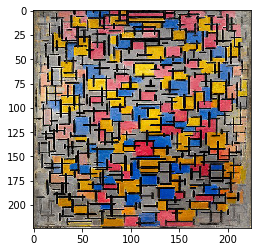

In [32]:
plt.imshow(img_style)

In [33]:
img_arr_style = np.expand_dims(img_style, axis=0)

img_arr_style.shape

(1, 224, 224, 3)

In [0]:
# extract style feature from style image

input_style = tf.keras.layers.Input(shape=input_shape, name='input_style')

style_outputs = []
x = tf.keras.layers.Lambda(norm_vgg16)(input_style)


for layer in vgg16.layers:
  x = layer(x)
  if layer.name in style_layer_names:
    style_outputs.append(x)

model_style = tf.keras.Model(
    inputs = input_style,
    outputs = style_outputs
)

# extract ground truth feature from style image
y_true_style = model_style.predict(img_arr_style)




In [0]:
input_con = tf.keras.layers.Input(shape=input_shape, name='input_con')

contents_outputs = []

y = tf.keras.layers.Lambda(norm_vgg16)(input_con)

for layer in vgg16.layers:
  y = layer(y)
  if layer.name in contents_layer_names:
    contents_outputs.append(y)

model_con = tf.keras.Model(
    inputs=input_con,
    outputs = contents_outputs
)

In [0]:
# rapper function to read image

def load_imgs(img_paths, target_size=(224, 224)):
  _load_img = lambda x: load_img(x, target_size=target_size)
  img_list = [
              np.expand_dims(_load_img(img_path), axis=0) for img_path in img_paths
  ]
  return np.concatenate(img_list, axis=0)



In [0]:
import math

def train_generator(img_paths, batch_size, model, y_true_style, shuffle=True, epochs=None):
  n_samples = len(img_paths)
  indices = list(range(n_samples))
  steps_per_epoch = math.ceil( n_samples / batch_size )

  img_paths = np.array(img_paths)
  cnt_epoch = 0
  while True:
    cnt_epoch += 1
    if shuffle:
      np.random.shuffle(indices)
    for i in range(steps_per_epoch):
      start = batch_size * i
      end = batch_size * (i+1)

      X = load_imgs(img_paths[indices[start:end]])

      batch_size_act = X.shape[0]

      y_true_style_t = [
                        np.repeat(feat, batch_size_act, axis=0) for feat in y_true_style
      ]

      # extract content's feature
      y_true_con = model.predict(X)
      yield (X, y_true_style_t + [y_true_con])
  if epochs is not None:
    if cnt_epoch >= epochs:
      raise StopIteration


In [0]:
# create generator

import glob

# path to input images

path_glob = os.path.join(path_to_images)
img_paths = glob.glob(path_glob)

batch_size = 2
epochs = 10

gen  = train_generator(
    img_paths,
    batch_size,
    model_con,
    y_true_style,
    epochs = epochs
)



In [0]:
# loss function

from tensorflow.keras import backend as K

def feature_loss(y_true, y_pred):
  norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
  return K.sum(K.square(y_pred - y_true), axis=(1,2,3))


In [0]:
def gram_matrix(X):
  X_sw = K.permute_dimensions(
      X, (0, 3, 2, 1)
  )
  s = K.shape(X_sw)
  new_shape = (s[0], s[1], s[2]*s[3])
  X_rs = K.reshape(X_sw, new_shape)
  X_rs_t = K.permute_dimensions(X_rs, (0, 2, 1))
  dot = K.batch_dot(X_rs, X_rs_t)
  norm = K.prod(K.cast(s[1:], 'float32'))

  return dot / norm

In [0]:
def style_loss(y_true, y_pred):
  return K.sum(K.square(gram_matrix(y_pred) - gram_matrix(y_true)), axis=(1,2))


# Training

In [0]:
import datetime

dt = datetime.datetime.now()
dir_log = 'model/{:%y%m%d_%H%M%S}'.format(dt)
dir_weights = 'model/{:%y%m%d_%H%M%S}/weights'.format(dt)
dir_trans = 'model/{:%y%m%d_%H%M%S}/img_trans'.format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

In [0]:
# compile

model.compile(
    optimizer = 'adam',
    loss = [ style_loss, style_loss, style_loss, style_loss, feature_loss],
    loss_weights = [1.0, 1.0, 1.0, 1.0, 3.0]

)

In [0]:
import pickle
img_test = load_img('DIV2K_train_LR_x8/0373x8.png', target_size=input_shape[:2])

img_arr_test = np.expand_dims(img_test, axis=0)

steps_per_epoch = math.ceil (len(img_paths)/batch_size)

iters_verbose = 10
iters_save_img = 10
iters_save_model = steps_per_epoch

# do train
now_epoch = 0
losses = []
path_tmp = 'epoch_{}_iters_{}_loss_{:2f}_{}'

for i, (x_train, y_train) in enumerate(gen):
  
  if i % steps_per_epoch == 0:
    now_epoch += 1

  # train
  loss = model.train_on_batch(x_train, y_train)
  losses.append (loss)

  # disp intermidiate result
  if i % iters_verbose == 0:
    print('epoch:{}, iters:{}, loss:{:.3f}'.format(now_epoch, i, loss[0]))

  # save images
  if i % iters_save_img == 0:
    pred = model_gen.predict(img_arr_test)
    #print(pred.shape, pred.dtype)
    img_pred = array_to_img(pred.squeeze())
    path_trs_img = path_tmp.format(now_epoch, i, loss[0], '.png')
    img_pred.save(os.path.join(dir_trans, path_trs_img))

    print('# imge save:{}'.format(path_trs_img))

  # save model, and loss
  if i % iters_save_model == 0:
    model.save(os.path.join(dir_weights, 
                            path_tmp.format(now_epoch, i, loss[0], '.h')))
    path_loss = os.path.join(dir_log, 'loss.pkl')
    with open(path_loss, 'wb') as f:
      pickle.dump(losses, f)

epoch:1, iters:0, loss:32395474.000
# imge save:epoch_1_iters_0_loss_32395474.000000_.png
INFO:tensorflow:Assets written to: model/191203_125221/weights/epoch_1_iters_0_loss_32395474.000000_.h/assets
epoch:1, iters:10, loss:34154736.000
# imge save:epoch_1_iters_10_loss_34154736.000000_.png
epoch:1, iters:20, loss:32207556.000
# imge save:epoch_1_iters_20_loss_32207556.000000_.png
epoch:1, iters:30, loss:26202108.000
# imge save:epoch_1_iters_30_loss_26202108.000000_.png
epoch:1, iters:40, loss:24935646.000
# imge save:epoch_1_iters_40_loss_24935646.000000_.png
epoch:1, iters:50, loss:20043978.000
# imge save:epoch_1_iters_50_loss_20043978.000000_.png
epoch:1, iters:60, loss:24614442.000
# imge save:epoch_1_iters_60_loss_24614442.000000_.png
epoch:1, iters:70, loss:31927490.000
# imge save:epoch_1_iters_70_loss_31927490.000000_.png
epoch:1, iters:80, loss:22916722.000
# imge save:epoch_1_iters_80_loss_22916722.000000_.png
epoch:1, iters:90, loss:20367358.000
# imge save:epoch_1_iters_9